In [1]:
#This notebook was used for experimental purposes (hyperparamter optimization and visualization of the training process). It was run directly on google colab

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

! ls ./drive/MyDrive/ML/Projet2_Road_Segmentation/Ressources/training/out/

/bin/bash: nvidia-smi: command not found
ls: ./drive/MyDrive/ML/Projet2_Road_Segmentation/Ressources/training/out/: No such file or directory


In [2]:
#from google.colab import drive
#drive._mount('/content/drive',force_remount=True)

import tensorflow as tf
import os
import sys
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import h5py
import time


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


In [3]:
# Constants
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3

# MODEL_CONSTANTS
DROPOUT_PERCENTAGE = 0.2
CONVOLUTION_WINDOW = (4,4)
POOLING_WINDOW = (2,2)
DECONVOLUTION_WINDOW = (2,2)
LEARNING_RATE = 1e-4


#helper functions 

from keras import backend as K
#Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


 


In [4]:
# Model
#dropouts were added to avoid overfitting

#Encoder Path
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

#transform input which can be integer value into floating point values
#transform = tf.keras.layers.Lambda(lambda x : x / 1.0)(inputs)
#transform = tf.keras.layers.Normalization(axis=-1)(inputs)

#first convolution
c1 = tf.keras.layers.Conv2D(32, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(inputs)
c1 = tf.keras.layers.BatchNormalization() (c1)
c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)
c1 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(c1)
c1 = tf.keras.layers.Conv2D(32, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(c1)
c1 = tf.keras.layers.BatchNormalization() (c1)
c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)

#first pooling
p1 = tf.keras.layers.MaxPooling2D(POOLING_WINDOW)(c1)

#second convolution
c2 = tf.keras.layers.Conv2D(64,CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.BatchNormalization() (c2)
c2 = tf.keras.layers.LeakyReLU(alpha=0.1)(c2)
c2 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(c2)
c2 = tf.keras.layers.Conv2D(64, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(c2)
c2 = tf.keras.layers.BatchNormalization() (c2)
c2 = tf.keras.layers.LeakyReLU(alpha=0.1)(c2)

#second pooling
p2 = tf.keras.layers.MaxPooling2D(POOLING_WINDOW)(c2)

#third convolution
c3 = tf.keras.layers.Conv2D(128, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(p2)
c3 = tf.keras.layers.BatchNormalization() (c3)
c3 = tf.keras.layers.LeakyReLU(alpha=0.1)(c3)
c3 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(c3)
c3 = tf.keras.layers.Conv2D(128, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(c3)
c3 = tf.keras.layers.BatchNormalization() (c3)
c3 = tf.keras.layers.LeakyReLU(alpha=0.1)(c3)

#third pooling
p3 = tf.keras.layers.MaxPooling2D(POOLING_WINDOW)(c3)

#fourth convolution
c4 = tf.keras.layers.Conv2D(256, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(p3)
c4 = tf.keras.layers.BatchNormalization() (c4)
c4 = tf.keras.layers.LeakyReLU(alpha=0.1)(c4)
c4 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(c4)
c4 = tf.keras.layers.Conv2D(256, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(c4)
c4 = tf.keras.layers.BatchNormalization() (c4)
c4 = tf.keras.layers.LeakyReLU(alpha=0.1)(c4)

#fourth pooling
p4 = tf.keras.layers.MaxPooling2D(POOLING_WINDOW)(c4)

#fifth convolution
c5 = tf.keras.layers.Conv2D(512, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(p4)
c5 = tf.keras.layers.BatchNormalization() (c5)
c5 = tf.keras.layers.LeakyReLU(alpha=0.1)(c5)
c5 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(c5)
c5 = tf.keras.layers.Conv2D(512, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(c5)
c5 = tf.keras.layers.BatchNormalization() (c5)
c5 = tf.keras.layers.LeakyReLU(alpha=0.1)(c5)


#Decoder Path
#at each step we concatenate the results from the encoder path with the results from the deocder path => improves image segmentation


#first upsampling
u1 = tf.keras.layers.Conv2DTranspose(256, DECONVOLUTION_WINDOW, strides = (2,2), padding="same")(c5)
u1 = tf.keras.layers.concatenate([u1, c4])
u1 = tf.keras.layers.Conv2D(256, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u1)
u1 = tf.keras.layers.BatchNormalization() (u1)
u1 = tf.keras.layers.LeakyReLU(alpha=0.1)(u1)
u1 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(u1)
u1 = tf.keras.layers.Conv2D(256, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u1)
u1 = tf.keras.layers.BatchNormalization() (u1)
u1 = tf.keras.layers.LeakyReLU(alpha=0.1)(u1)

#second upsampling
u2 = tf.keras.layers.Conv2DTranspose(128, DECONVOLUTION_WINDOW, strides = (2,2), padding="same")(u1)
u2 = tf.keras.layers.concatenate([u2, c3])
u2 = tf.keras.layers.Conv2D(128, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u2)
u2 = tf.keras.layers.BatchNormalization() (u2)
u2 = tf.keras.layers.LeakyReLU(alpha=0.1)(u2)
u2 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(u2)
u2 = tf.keras.layers.Conv2D(128, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u2)
u2 = tf.keras.layers.BatchNormalization() (u2)
u2 = tf.keras.layers.LeakyReLU(alpha=0.1)(u2)

#third upsampling
u3 = tf.keras.layers.Conv2DTranspose(64, DECONVOLUTION_WINDOW, strides = (2,2), padding="same")(u2)
u3 = tf.keras.layers.concatenate([u3, c2])
u3 = tf.keras.layers.Conv2D(64, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u3)
u3 = tf.keras.layers.BatchNormalization() (u3)
u3 = tf.keras.layers.LeakyReLU(alpha=0.1)(u3)
u3 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(u3)
u3 = tf.keras.layers.Conv2D(64, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u3)
u3 = tf.keras.layers.BatchNormalization() (u3)
u3 = tf.keras.layers.LeakyReLU(alpha=0.1)(u3)

#fourth upsampling
u4 = tf.keras.layers.Conv2DTranspose(32, DECONVOLUTION_WINDOW, strides = (2,2), padding="same")(u3)
u4 = tf.keras.layers.concatenate([u4, c1])
u4 = tf.keras.layers.Conv2D(32, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u4)
u4 = tf.keras.layers.BatchNormalization() (u4)
u4 = tf.keras.layers.LeakyReLU(alpha=0.1)(u4)
u4 = tf.keras.layers.Dropout(DROPOUT_PERCENTAGE)(u4)
u4 = tf.keras.layers.Conv2D(32, CONVOLUTION_WINDOW,  kernel_initializer="he_normal",padding="same")(u4)
u4 = tf.keras.layers.BatchNormalization() (u4)
u4 = tf.keras.layers.LeakyReLU(alpha=0.1)(u4)



out = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(u4)


# ********** test **********
#reshape to get matching dimensions
#out = tf.keras.layers.Reshape((IMG_WIDTH * IMG_HEIGHT, 1))(out)

# ********** test **********
model = tf.keras.Model(inputs = [inputs], outputs=[out])



#"binary_crossentropy"

#Still Unet with 2400 samples but this time trying with soft_dice_loss in order to remove class imbalance and using iou coefficient as metric
model.compile(optimizer=tf.keras.optimizers.Adam(lr = LEARNING_RATE),loss='binary_crossentropy',metrics=[f1_m])
# "accuracy",
print(model.summary())

#tf.keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  1568        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/Users/abiola/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# Define our data (inputs and labels)
#root_dir = "./drive/MyDrive/ML/Projet2_Road_Segmentation/Ressources/"
root_dir = "/Users/abiola/Documents/EPFL/ML_Project2_Road_Segmentation/Ressources/"

files_dir = root_dir + "training/"

!ls files_dir

startTime = time.time()
with h5py.File(files_dir + 'LABELS_100.h5', 'r') as hf:
    gt_imgs = hf['LABELS_100'][:]

endTime = time.time()

print("--- Time to load labels: %s seconds ---" % (time.time() - startTime))

startTime = time.time()
with h5py.File(files_dir + 'IMGS_100.h5', 'r') as hf:
    imgs = hf['IMGS_100'][:]

#endTime = time.time()

print("--- Time to load images: %s seconds ---" % (time.time() - startTime))



ls: files_dir: No such file or directory
--- Time to load labels: 0.06673908233642578 seconds ---
--- Time to load images: 0.15900897979736328 seconds ---


In [13]:
X_train = imgs
Y_train = gt_imgs.reshape((len(gt_imgs),IMG_HEIGHT,IMG_WIDTH,1))


#take only first 2 images
X_train = X_train[:10]
Y_train = Y_train[:10]

#datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

#X_Y_train_flow = datagen.flow(X_train,Y_train,batch_size = 400,subset='training')
#X_Y_validation_flow = datagen.flow(X_train,Y_train,batch_size = 100,subset='validation')

In [14]:
print(Y_train.shape)
print(X_train.shape)

(10, 400, 400, 1)
(10, 400, 400, 3)


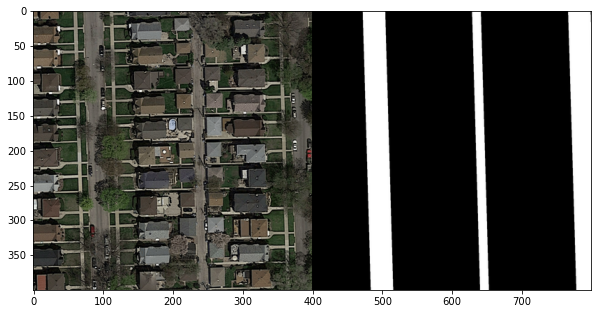

In [20]:
# Show some images to see if everything is fine

PIXEL_DEPTH = 255

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    n_channels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if n_channels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

idx = random.randint(0, len(X_train)-1)
#elem = X_test[idx]



gt = Y_train.reshape((-1,400,400))
cimg = concatenate_images(X_train[idx],gt[idx])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [16]:
# PARAMS FOR MODEL
VALIDATION_SPLIT = 0
BATCH_SIZE = 5
EPOCHS = 100
EARLY_STOPPAGE = 10

In [17]:
##Callbacks for fit methods

#1. checkpoints to save timestamps of model during training
checkpoints = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/ML/Projet2_Road_Segmentation/road_semgentation_unet8.h5", verbose=1, save_best_only = True)

#2. eraly stopping callback to avoid useless epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPAGE, monitor="iou_coef",restore_best_weights = True)
#val_loss

#3. tensorboard to visulaize various statistics during training
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

#4. dynamically adjust learning rate when training is not progressing well

dynamic_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, verbose=1, epsilon=1e-4, min_lr=0.000001)

callbacks = [checkpoints,dynamic_lr,tensorboard]


In [18]:
# Our data is skewed: we have way more background pixels than road pixels, therefore it is important to give more weight to the road samples

#nb_training_samples = len(Y_train)
#sample_weight = np.zeros((nb_training_samples,IMG_WIDTH*IMG_HEIGHT))
#print(sample_weight.shape)
#sample_weight[:,0] += 1
#sample_weight[:,1] += 2



In [19]:
#model = tf.keras.models.load_model("./drive/MyDrive/ML/Projet2_Road_Segmentation/road_semgentation_unet5.h5",custom_objects={'f1_m': f1_m})



results = model.fit(X_train,Y_train, batch_size =BATCH_SIZE, epochs = EPOCHS)
                    #sample_weight=sample_weight)
                    #.reshape((nb_training_samples,IMG_WIDTH*IMG_HEIGHT,1))
#


Epoch 1/100
2/2 [==============================] - 44s 24s/step - loss: 0.9451 - f1_m: 0.3299
Epoch 2/100
2/2 [==============================] - 46s 22s/step - loss: 0.7224 - f1_m: 0.4010
Epoch 3/100
2/2 [==============================] - 30s 15s/step - loss: 0.5831 - f1_m: 0.5033
Epoch 4/100
2/2 [==============================] - 32s 14s/step - loss: 0.5198 - f1_m: 0.5282
Epoch 5/100
2/2 [==============================] - 30s 14s/step - loss: 0.5284 - f1_m: 0.4967
Epoch 6/100
2/2 [==============================] - 25s 12s/step - loss: 0.4750 - f1_m: 0.5134
Epoch 7/100
2/2 [==============================] - 27s 14s/step - loss: 0.4610 - f1_m: 0.5059
Epoch 8/100
2/2 [==============================] - 26s 13s/step - loss: 0.4480 - f1_m: 0.5497
Epoch 9/100
2/2 [==============================] - 26s 13s/step - loss: 0.4420 - f1_m: 0.5133
Epoch 10/100
2/2 [==============================] - 29s 14s/step - loss: 0.4332 - f1_m: 0.5362
Epoch 11/100
2/2 [==============================] - 26s 14s

2/2 [==============================] - 29s 15s/step - loss: 0.2413 - f1_m: 0.9412
Epoch 88/100
2/2 [==============================] - 28s 14s/step - loss: 0.2446 - f1_m: 0.9338
Epoch 89/100
2/2 [==============================] - 29s 16s/step - loss: 0.2414 - f1_m: 0.9396
Epoch 90/100
2/2 [==============================] - 30s 14s/step - loss: 0.2395 - f1_m: 0.9419
Epoch 91/100
2/2 [==============================] - 27s 13s/step - loss: 0.2363 - f1_m: 0.9480
Epoch 92/100
2/2 [==============================] - 26s 13s/step - loss: 0.2383 - f1_m: 0.9410
Epoch 93/100
2/2 [==============================] - 26s 13s/step - loss: 0.2375 - f1_m: 0.9439
Epoch 94/100
2/2 [==============================] - 26s 14s/step - loss: 0.2375 - f1_m: 0.9435
Epoch 95/100
2/2 [==============================] - 27s 14s/step - loss: 0.2358 - f1_m: 0.9465
Epoch 96/100
2/2 [==============================] - 26s 13s/step - loss: 0.2361 - f1_m: 0.9459
Epoch 97/100
2/2 [==============================] - 25s 12s/ste